In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
MAX_SEQUENCE_LENGTH = 5000
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300
TEST_SPLIT = 0.2

TEXT_DATA = 'data/fake_or_real_news.csv'

In [3]:
# define a function that allows us to evaluate our models

from sklearn.metrics import accuracy_score

def evaluate_model(predict_fun, X_train, y_train, X_test, y_test):
    '''
    evaluate the model, both training and testing errors are reported
    '''
    # training error
    y_predict_train = predict_fun(X_train)
    train_acc = accuracy_score(y_train,y_predict_train)
    
    # testing error
    y_predict_test = predict_fun(X_test)
    test_acc = accuracy_score(y_test,y_predict_test)
    
    return train_acc, test_acc

In [4]:
# estimate 95% confidence interval on error

# NOTE: based on conversation on stackexchange: 
# https://stats.stackexchange.com/questions/247551/how-to-determine-the-confidence-of-a-neural-network-prediction
# towards bottom of the page.

from math import sqrt

def error_conf(error, n):
    term = 1.96*sqrt((error*(1-error))/n)
    lb = error - term
    ub = error + term
    
    return lb, ub

In [5]:
# read in our data and preprocess it

df = pd.read_csv(TEXT_DATA)
df.drop(labels=['id','title'], axis='columns', inplace=True)
# only select stories with lengths gt 0 -- there are some texts with len = 0
mask = list(df['text'].apply(lambda x: len(x) > 0))
df = df[mask]

In [6]:
# prepare text samples and their labels

texts = df['text']
labels = df['label']

print('Found %s texts.' %texts.shape[0])

Found 6335 texts.


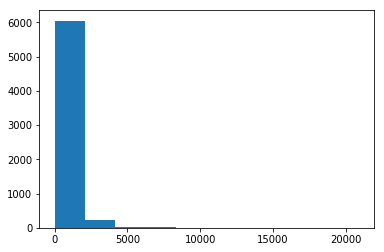

In [7]:
# plot the distribution of article lengths in terms of word counts

text_lengths = texts.apply(lambda x: len(x.split(" ")))
plt.hist(text_lengths)
plt.show()

## Naive Bayes

In [8]:
# set up vector models for training and testing

from sklearn.feature_extraction.text import CountVectorizer

# data vectorizer
vectorizer = CountVectorizer(analyzer = "word", 
                             binary = True, 
                             min_df = 2,
                             stop_words='english')
docarray = vectorizer.fit_transform(texts).toarray()
docterm = pd.DataFrame(docarray, columns=vectorizer.get_feature_names())

In [9]:
# create training and test data

from sklearn.model_selection import train_test_split
docterm_train, docterm_test, y_train, y_test = train_test_split(docterm, labels, test_size=TEST_SPLIT)

In [10]:
# Naive Bayes Model

from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(docterm_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
# evaluate model

train_acc, test_acc = evaluate_model(model.predict, docterm_train, y_train, docterm_test, y_test)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 93.92%
Testing Accuracy: 88.63%


In [12]:
# estimate 95% confidence interval

n = docterm_test.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("95% confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 86.89%-90.38%


## Convolutional DNN

In [13]:
# vectorize the text samples into a 2D integer tensor 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
data = pad_sequences(sequences, 
                     maxlen=MAX_SEQUENCE_LENGTH, 
                     padding='pre', 
                     truncating='pre')

print('Found %s unique tokens.' % len(word_index))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Using TensorFlow backend.


Found 99682 unique tokens.
Shape of data tensor: (6335, 5000)
Shape of label tensor: (6335,)


In [14]:
# split the data into a training set and a validation set   

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(data, 
                                                  labels.apply(lambda x: 0 if x == 'FAKE' else 1), 
                                                  test_size=TEST_SPLIT)

In [15]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(num_words,
                         EMBEDDING_DIM, 
                         input_length=MAX_SEQUENCE_LENGTH,
                         trainable=True),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5000, 300)         7500300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 128)         192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,709,069
Trainable params: 7,709,069
Non-trainable params: 0
_________________________________________________________________


In [16]:

# training
TRAINING_BATCH_SIZE      = 32
# TRAINING_SHUFFLE_BUFFER  = 5000
# TRAINING_BN_MOMENTUM     = 0.99
# TRAINING_BN_EPSILON      = 0.001
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 3
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 7

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
!mkdir -p "$SAVE_MODEL_PATH"

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file ./save/model/ already exists.
Error occurred while processing: ./save/model/.


In [17]:
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = ((TRAINING_LR_MAX - TRAINING_LR_FINAL)*
              max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/
                                 (TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + 
              TRAINING_LR_FINAL)

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

In [18]:
# train the model
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', 
                                             save_best_only=True, monitor='val_loss', verbose=1)]

initial_epoch_num = 0
# example of restarting training after a crash from the last saved checkpoint
# model.load_weights(SAVE_MODEL_PATH+'model_5.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = 5                            # replace X with the last saved checkpoint number


history           = model.fit(x_train, 
                              y_train,shuffle=True,batch_size=TRAINING_BATCH_SIZE,
                              epochs=TRAINING_NUM_EPOCHS, 
                              verbose=1, 
                              callbacks=callbacks, 
                              validation_data=(x_val, y_val), 
                              initial_epoch=initial_epoch_num)

# previous version with 97% testing accuracy
# history = model.fit(x_train, 
#                     y_train,
#                     batch_size=128,
#                     epochs=10,
#                     validation_data=(x_val, y_val))


Train on 5068 samples, validate on 1267 samples
Epoch 1/10
5068/5068 [==============================] - 541s 107ms/step - loss: 0.6920 - accuracy: 0.5274 - val_loss: 0.6897 - val_accuracy: 0.6938

Epoch 00001: val_loss improved from inf to 0.68966, saving model to ./save/model/model_1.h5
Epoch 2/10
5068/5068 [==============================] - 532s 105ms/step - loss: 0.3196 - accuracy: 0.9037 - val_loss: 0.0994 - val_accuracy: 0.9700

Epoch 00002: val_loss improved from 0.68966 to 0.09935, saving model to ./save/model/model_2.h5
Epoch 3/10
5068/5068 [==============================] - 528s 104ms/step - loss: 0.0494 - accuracy: 0.9860 - val_loss: 0.0540 - val_accuracy: 0.9811

Epoch 00003: val_loss improved from 0.09935 to 0.05400, saving model to ./save/model/model_3.h5
Epoch 4/10
5068/5068 [==============================] - 534s 105ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.0423 - val_accuracy: 0.9842

Epoch 00004: val_loss improved from 0.05400 to 0.04230, saving model to

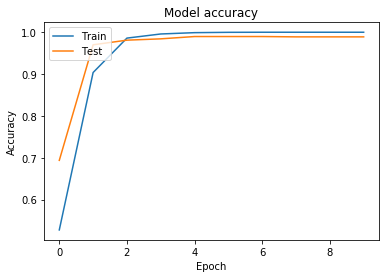

In [23]:
# Plot training & validation accuracy values
# print(history.history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# model.load_weights(SAVE_MODEL_PATH+'model_5.h5')

In [25]:
# evaluate model

def predict(X):
    return np.rint(model.predict(X)) # threshold the predictions to retrieve labels

train_acc, test_acc = evaluate_model(predict,
                                     x_train, 
                                     y_train, 
                                     x_val, 
                                     y_val)
print("Training Accuracy: {:.2f}%".format(train_acc*100))
print("Testing Accuracy: {:.2f}%".format(test_acc*100))

Training Accuracy: 100.00%
Testing Accuracy: 98.90%


In [26]:
# estimate 95% confidence interval

n = x_val.shape[0]
lb, ub = error_conf(1-test_acc, n)

print("confidence interval: {:.2f}%-{:.2f}%".format((1-ub)*100,(1-lb)*100))

95% confidence interval: 98.32%-99.47%


In [48]:
df['label']


0       FAKE
1       FAKE
2       REAL
3       FAKE
4       REAL
5       FAKE
6       FAKE
7       REAL
8       REAL
9       REAL
10      REAL
11      REAL
12      FAKE
13      FAKE
14      REAL
15      REAL
16      FAKE
17      FAKE
18      REAL
19      REAL
20      REAL
21      FAKE
22      REAL
23      REAL
24      FAKE
25      REAL
26      REAL
27      REAL
28      REAL
29      FAKE
        ... 
6305    FAKE
6306    FAKE
6307    FAKE
6308    FAKE
6309    REAL
6310    REAL
6311    REAL
6312    FAKE
6313    FAKE
6314    FAKE
6315    REAL
6316    REAL
6317    FAKE
6318    FAKE
6319    REAL
6320    FAKE
6321    FAKE
6322    FAKE
6323    REAL
6324    REAL
6325    FAKE
6326    FAKE
6327    REAL
6328    FAKE
6329    FAKE
6330    REAL
6331    FAKE
6332    FAKE
6333    REAL
6334    REAL
Name: label, Length: 6335, dtype: object